# Predicting Heart Disease

The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, we will use the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

In [3]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [15]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/datasets/heart-disease-dataset.csv')


## EDA: Descriptive Statistics

We will start with exploring our dataset. As per the source, each patient has the following information collected about them:


1. `Age`: age of the patient [years]
2. `Sex`: sex of the patient [M: Male, F: Female]
3. `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. `RestingBP`: resting blood pressure [mm Hg]
5. `Cholesterol`: serum cholesterol [mm/dl]
6. `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
9. `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
10. `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
11. `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. `HeartDisease`: output class [1: heart disease, 0: Normal]

In [17]:
#load dataset
df = pd.read_csv("/content/drive/MyDrive/datasets/heart-disease-dataset.csv")

In [18]:
df.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0,2.0,1.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0,1.0,0.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0,1.5,2.0,1.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0,1.0,0.0


The dataset seems to contain both numerical and categorical features. Let's look at the datatype for each column.

In [19]:
print(df.dtypes)
df.dtypes.value_counts()

age                    float64
sex                    float64
chest_pain_type        float64
resting_bp_s           float64
cholesterol            float64
fasting_blood_sugar    float64
resting_ecg            float64
max_heart_rate         float64
exercise_angina        float64
oldpeak                float64
st_slope               float64
target                 float64
dtype: object


,count
float64,12


In [20]:
df.describe()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


From the table above, we can observe that:

- The average age of patients is ~`53` years.
- The median for `Cholesterol` is higher than its mean by roughly `25` mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `RestingBP` and `Cholesterol` have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

`RestingBP` can't be `0`. And, as per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be `0` as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, `HeartDisease`, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [21]:
df.isna().sum()

,0
age,0
sex,0
chest_pain_type,0
resting_bp_s,0
cholesterol,0
fasting_blood_sugar,0
resting_ecg,0
max_heart_rate,0
exercise_angina,0
oldpeak,0


There are no missing values in this dataset!

## EDA:


In [23]:
# Categorical columns = those with <= 10 unique values
cat_cols = [col for col in df.columns if df[col].nunique() <= 10]

# Numeric columns
num_cols = [col for col in df.columns if df[col].nunique() > 10]

print("Categorical Columns:", cat_cols)
print("Numeric Columns:", num_cols)


Categorical Columns: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_angina', 'st_slope', 'target']
Numeric Columns: ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak']


We can confirm that those columns are indeed categorical given the number of unique values in each of them. But, we can't gather much else. Also, `FastingBS` and `HeartDisease` are categorical as well since they only contain binary values. We can confirm that quickly as well.


===== sex =====
sex
1.0    909
0.0    281
Name: count, dtype: int64


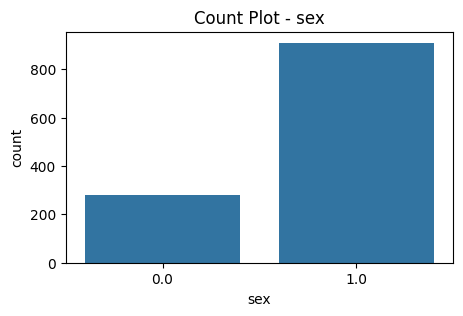


===== chest_pain_type =====
chest_pain_type
4.0    625
3.0    283
2.0    216
1.0     66
Name: count, dtype: int64


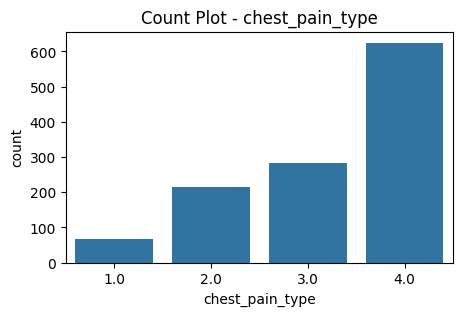


===== fasting_blood_sugar =====
fasting_blood_sugar
0.0    936
1.0    254
Name: count, dtype: int64


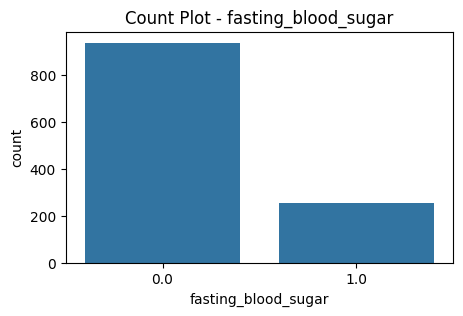


===== resting_ecg =====
resting_ecg
0.0    684
2.0    325
1.0    181
Name: count, dtype: int64


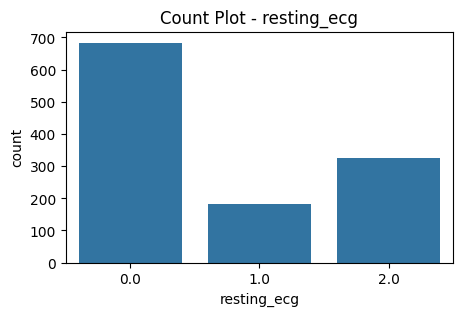


===== exercise_angina =====
exercise_angina
0.0    729
1.0    461
Name: count, dtype: int64


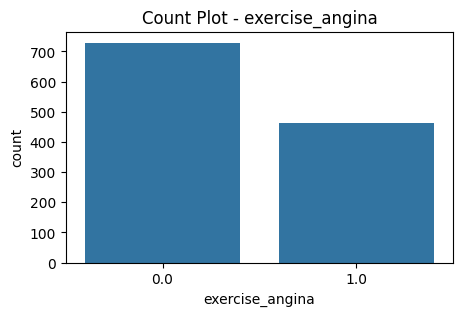


===== st_slope =====
st_slope
2.0    582
1.0    526
3.0     81
0.0      1
Name: count, dtype: int64


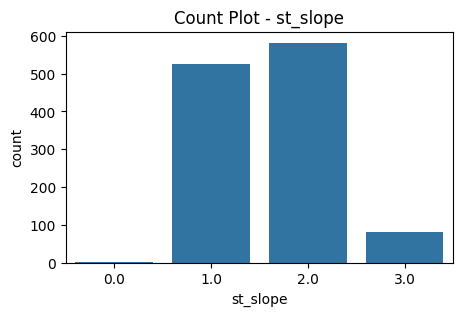


===== target =====
target
1.0    629
0.0    561
Name: count, dtype: int64


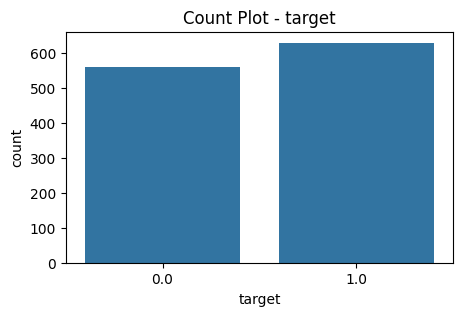

In [24]:
for col in cat_cols:
    print(f"\n===== {col} =====")
    print(df[col].value_counts())

    plt.figure(figsize=(5,3))
    sns.countplot(data=df, x=col)
    plt.title(f"Count Plot - {col}")
    plt.show()


Let's start looking at the categories in more detail.

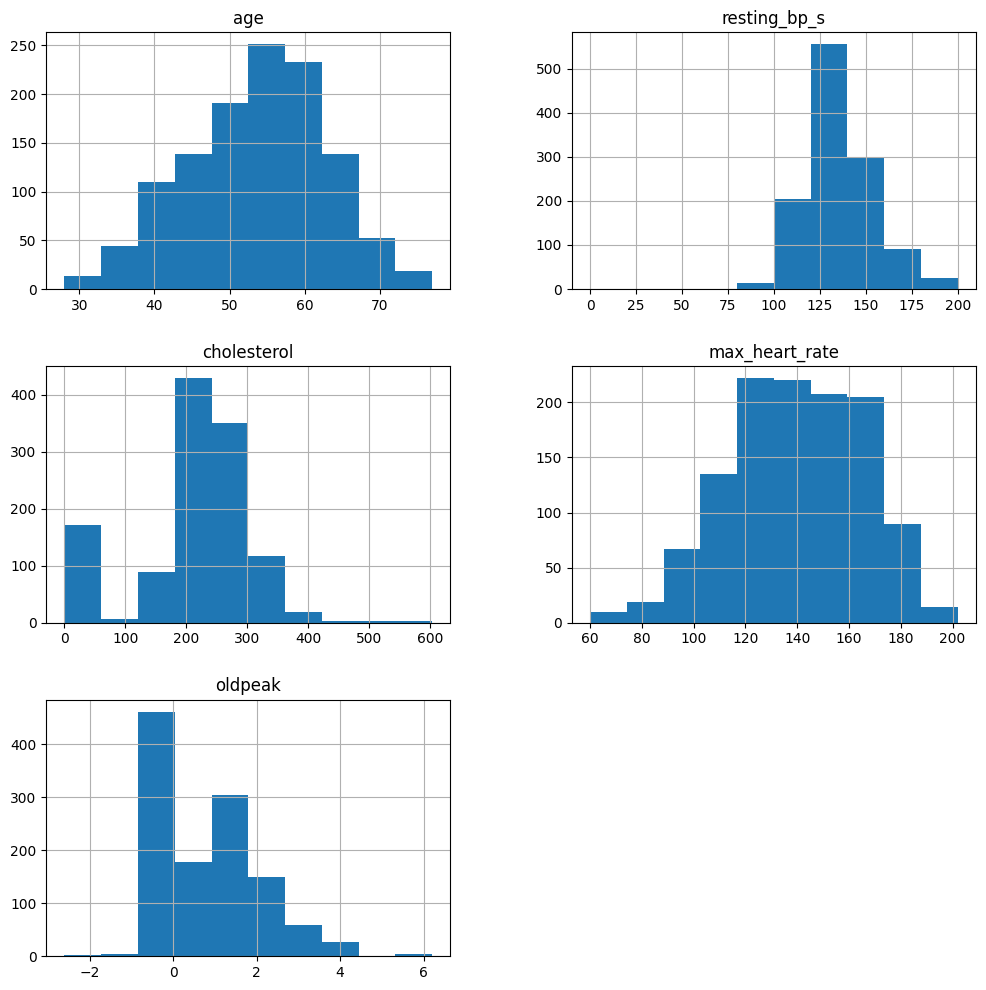

In [25]:
df[num_cols].hist(figsize=(12, 12))
plt.show()


- The dataset is highly skewed towards male patients. There are `725` male patients and `193` female patients. This could potentially induce a bias in our model.
- `496` patients had `ASY` (asymptotic) chest pain type.
- `552` patients had a normal restin ECG.
- `704` patients had blood sugar lower than `120` mg/dl

Grouping these by `HeartDisease` will give us a better idea about the data distribution.

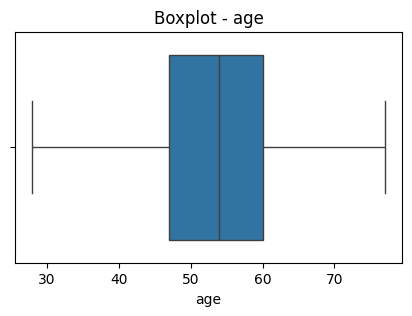

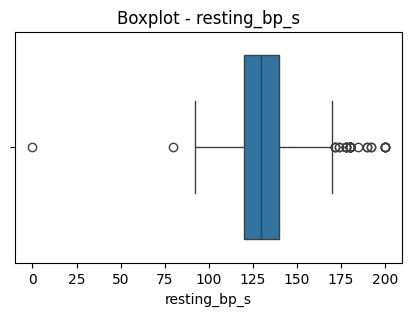

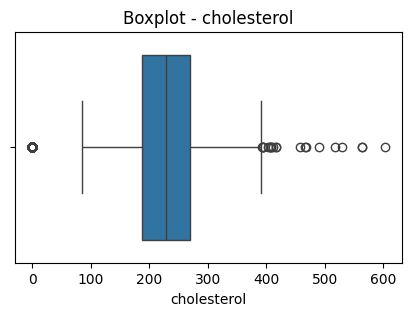

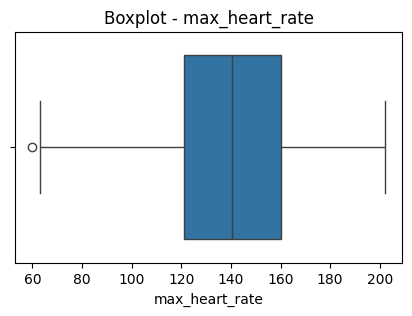

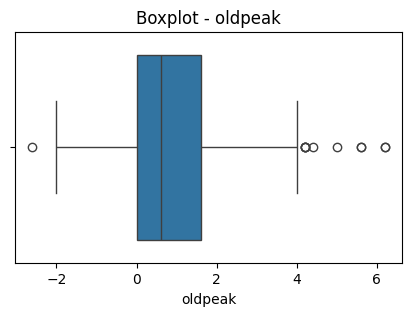

In [26]:
for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()


- We can further notice how skewed the dataset is towards male patients. Only `50` female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, `392`, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
- A high number (`170`) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, `316` were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, `381` were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

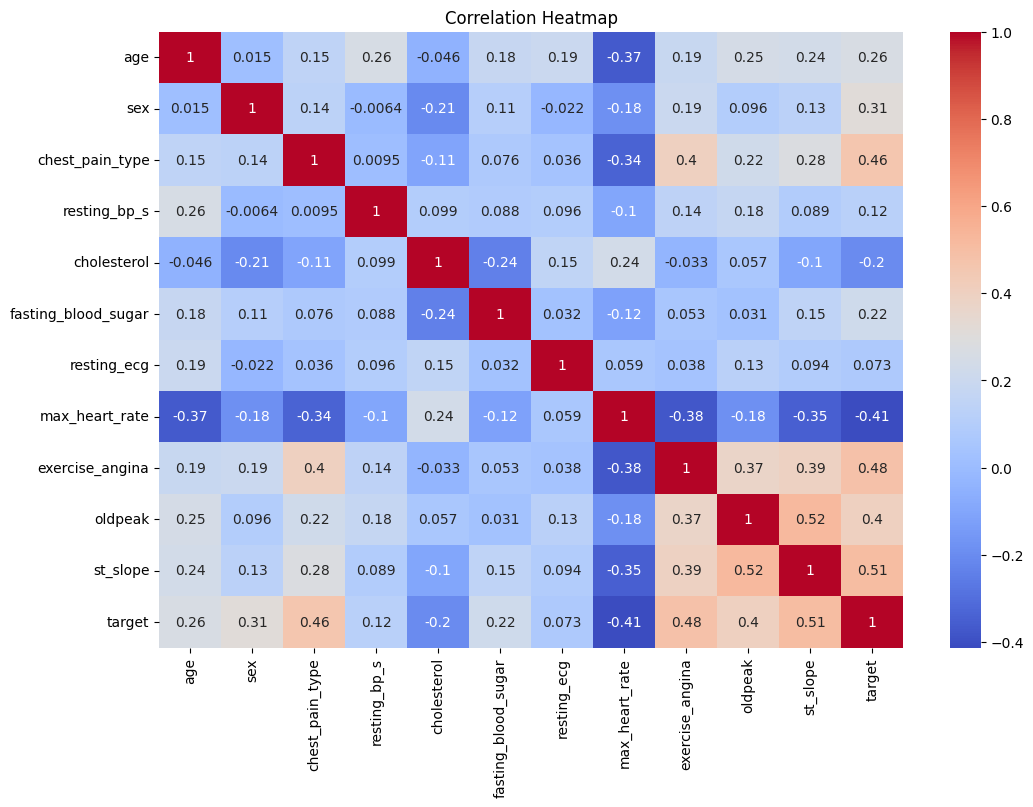

In [27]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
df[df["Cholesterol"] == 0]

`RestingBP` has only one zero value. We can remove that row from consideration. There are `172` zero values for `Cholesterol`. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in `Cholesterol` in relation to `HeartDisease`. So, the 0 values in `Cholesterol` for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [ ]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [ ]:
df_clean[["Cholesterol", "RestingBP"]].describe()

The minimum values for both have changed! There are no more zero values in either of those.

## Feature Selection

Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`


We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.

In [ ]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

Now, we can find how they are correlated.

In [8]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

NameError: name 'df_clean' is not defined

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to `HeartDisease`:

- `Oldpeak`
- `MaxHR`
- `ChestPainType_ATA`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

The correlation coefficient threshold was chosen arbitrarily. Surprisingly, `Cholesterol` is not strongly correlated to `HeartDisease`. We can consider ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:

- `Oldpeak`
- `Sex_M`
    - It has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account.
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

Time to create our model using these features!

## Building a Classifier with One Feature

We will split our dataset into a training and a test set first.

In [ ]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

We will start with creating a model for each of the features above and evaluate their performance using accuracy as a metric.

In [9]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

NameError: name 'features' is not defined

Our best forming model, with an accuracy of ~`82%`, was trained on the `ST_Slope_Flat` feature with `ExerciseAngina_Y` being a close second. These make sense given the data distributions we saw previously.

We will train a model using all of these features next.

## Building a Classifier with Multiple Features

Before training on all of the above features, we need to normalize the data first. We will use scikit-learn's MinMaxScaler to scale the values between 0 and 1, and then train the model again.

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [10]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

NameError: name 'X_train_scaled' is not defined

The model's accuracy jumped to ~`83%`! That's not a significant improvement, but still a good start. Using all these features results in an improved model, but, let's see what parameters/hyperparameters might be optimal.

## Hyperparameter Optimization

Let's prepare our data first.

In [ ]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

We will use grid search to explore the following range of values for a couple of hyperparameters:

- For `k` (`n_neighbors` in scikit-learn) we will use values in the range of 1 to 20.
- We will use two distance metrics - `minkwoski` and `manhattan`.

`minkwoski` is the default metric for KNeighborsClassifier in sklearn, so we don't expect `manhattan` to do better. But, let's see what happens!

In [ ]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

In [ ]:
knn_grid.best_score_*100, knn_grid.best_params_

Our best model had an accuracy of ~`83%` with `19` `n_neighbors` and `minkowski` as the distance metric.

The accuracy of this model is only slightly better. Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

We need to first normalize our test set similar to how we scaled our training set.

In [ ]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

Our model got an accuracy of ~`87`%. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~`87`% of the time.

However, the accuracy being higher than the one before raises some flags.

One explanation that could explain is to look at how the data is distributed.

In [ ]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

We used `Sex` as one of our features for training the model.

- `X` had `724` males and `193` females.
- `X_train` had `615` males and `164` females.
- `X_test` had `109` males and `29` females.


We can see that the above datasets have a significantly higher number of male patients than female ones. We briefly mentioned previously that this could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

## Summary and Next Steps

Our final model was trained using the following features:

- `Oldpeak`
- `Sex_M`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

and had a test set accuracy of `86.96`%. However, given the limitations of our data this accuracy might not be indicative of a well performing model.

There are quite a few things we could try next to get better results:

- Try out different features.
- Expand the grid search parameters to identify more optimal hyperparameters.
- Explore other algorithms that might perform better than k-NN.
- Try and collect more data.